# GIA comparison

## ICE6G and Simon et al. 2018

Build a function that takes lat/lon or tide gauge name as input and provides GIA at that location

More information about [ICE-6G here](https://www.atmosp.physics.utoronto.ca/~peltier/data.php)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import matplotlib.pyplot as plt

import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
# Sart with reading ICE6G. The text file is very anoying because columns are separated by space
# but there are also spaces in the names of the locations.
dir_ICE6G = '/Users/dewilebars/Projects/SLBudget/data/GIA/ICE6G/'

ICE6G_PSMSL_f = f'{dir_ICE6G}drsl.PSMSL.ICE6G_C_VM5a_O512.txt'

In [3]:
# First lists have to be read
lat = []
lon = []
locat = []
gia = []
name_tg = []
with open (dir_ICE6G + "drsl.PSMSL.ICE6G_C_VM5a_O512.txt", "r") as myfile:
    data = myfile.readlines()
for i in range(7,len(data)):
    line = data[i].split()
    lat.append(line[0])
    lon.append(line[1])
    locat.append(line[2])
    gia.append(line[-1])
    name_tg.append(line[4])
    
# Now build a pandas dataframe from these lists
gia_list = [("Lat", lat),
            ("Lon", lon),
            ("Location", locat),
            ("Name", name_tg),
            ("GIA", gia)]
gia_df = pd.DataFrame.from_dict(dict(gia_list))
gia_df.Location = gia_df.Location.astype(int)
gia_df.Lon = gia_df.Lon.astype(float)
gia_df.Lat = gia_df.Lat.astype(float)
gia_df.GIA = gia_df.GIA.astype(float)
gia_df = gia_df.set_index("Location")
gia_df = gia_df.sort_index()



In [4]:
tg_id=[20, 22, 23, 24, 25, 32]
gia_avg = (gia_df.loc[tg_id]).GIA.mean()

print(f'Average sea level for the main Dutch tide gauges: {round(gia_avg,2)}')

Average sea level for the main Dutch tide gauges: 0.37


In [5]:
time = np.arange(1900, 2020)
gia_ts = gia_avg * (time - time[0])
gia_ts_list = [("time", time),
              ("GIA", gia_ts)]
gia_ts_df = pd.DataFrame.from_dict(dict(gia_ts_list))
gia_ts_df = gia_ts_df.set_index("time")
gia_ts_df[-10:]

,GIA
time,
2010,40.516667
2011,40.885000
2012,41.253333
2013,41.621667
2014,41.990000
2015,42.358333
2016,42.726667
2017,43.095000
2018,43.463333


## Plot maps of of radial displacement and relative sea level change due to GIA from ICE6G

In [6]:
def rotate_longitude(ds, name_lon):

    ds = ds.assign_coords({name_lon:(((ds[name_lon] + 180 ) % 360) - 180)})
    ds = ds.sortby(ds[name_lon])

    return ds

In [7]:
drad_ds = xr.open_dataset(f'{dir_ICE6G}drad.1grid_O512.nc')
dsea_ds = xr.open_dataset(f'{dir_ICE6G}dsea.1grid_O512.nc')

drad_ds = rotate_longitude(drad_ds, 'Lon')
dsea_ds = rotate_longitude(dsea_ds, 'Lon')

drad_ds = drad_ds.sortby(drad_ds['Lat'])
dsea_ds = dsea_ds.sortby(drad_ds['Lat'])

Influence of GIA on relative sea level

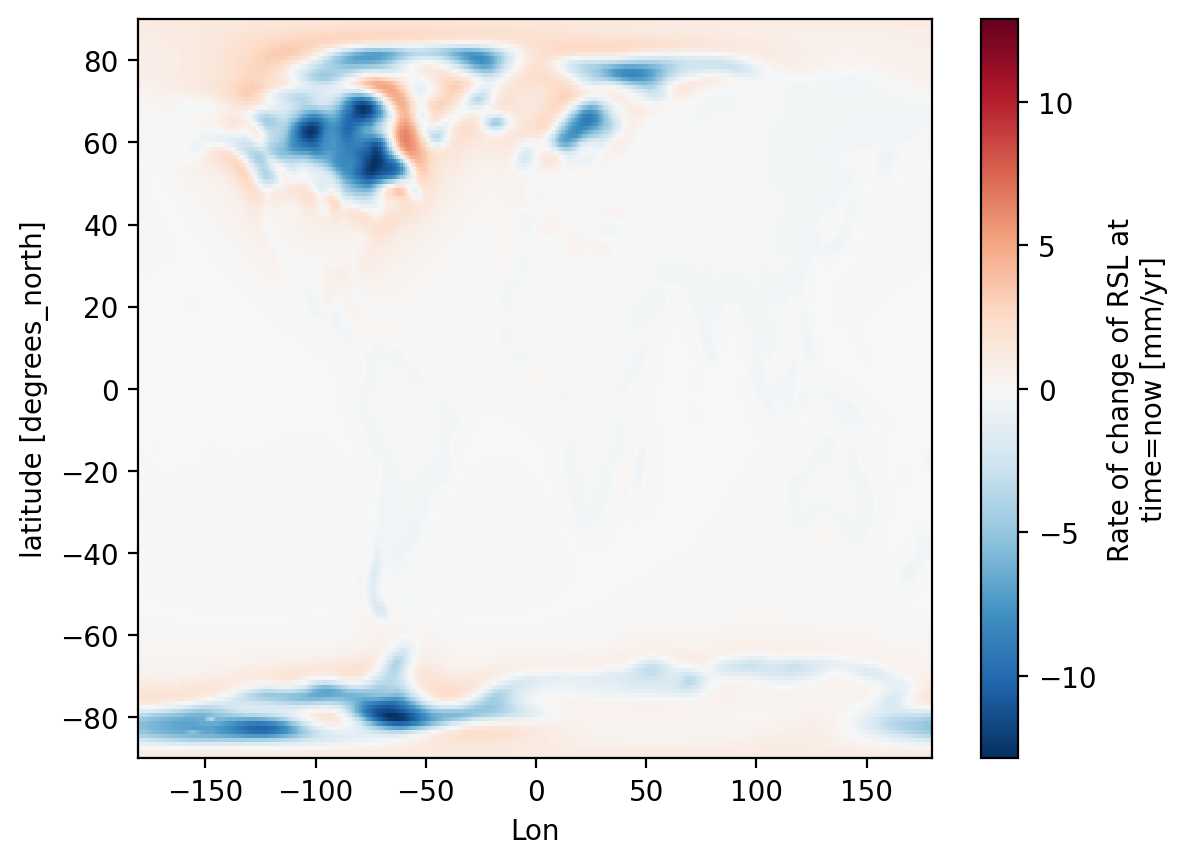

In [8]:
dsea_ds.Dsea_250.plot()

Influence of GIA on vertical land motion

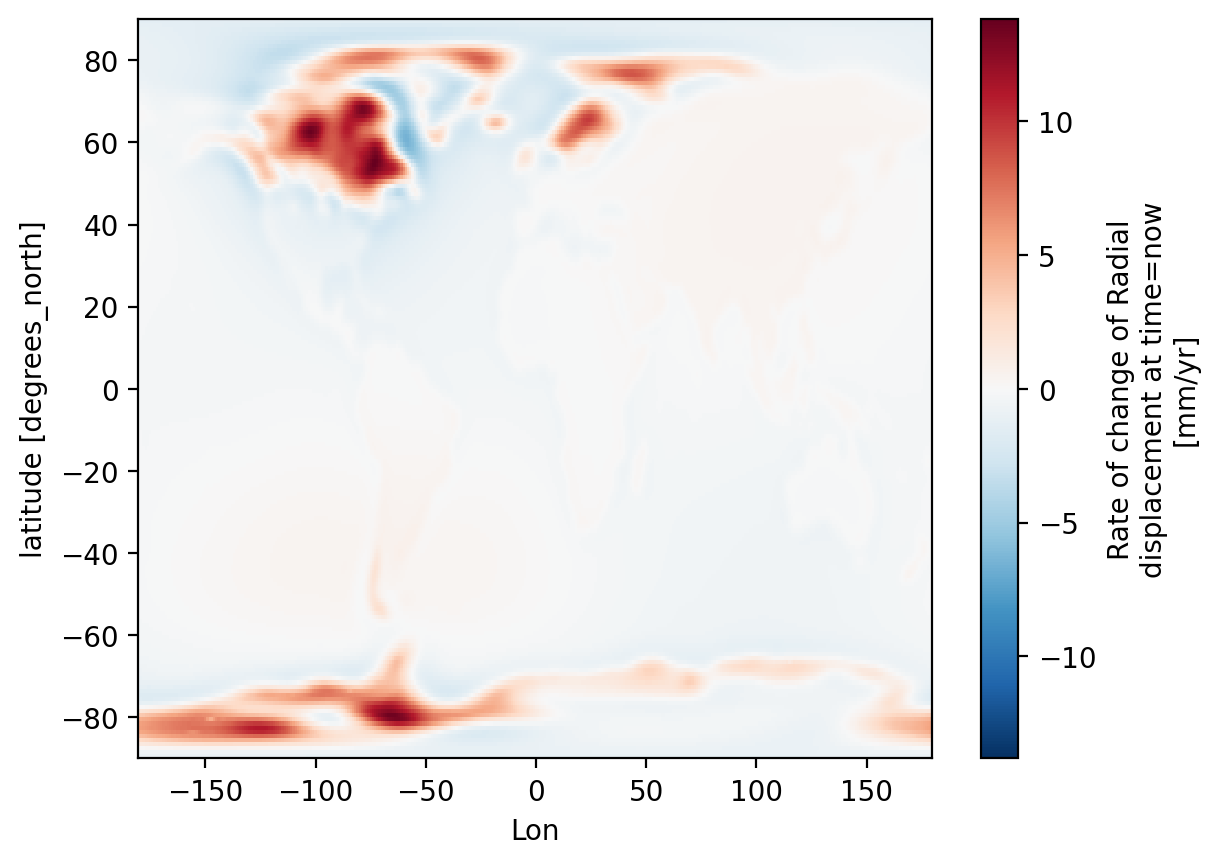

In [9]:
drad_ds.Drad_250.plot()

The influence of GIA on absolute sea level is the sum of relative sea level and vertical land motion

In [10]:
abs_da = dsea_ds.Dsea_250+drad_ds.Drad_250

abs_da = abs_da.sortby(abs_da['Lat'])

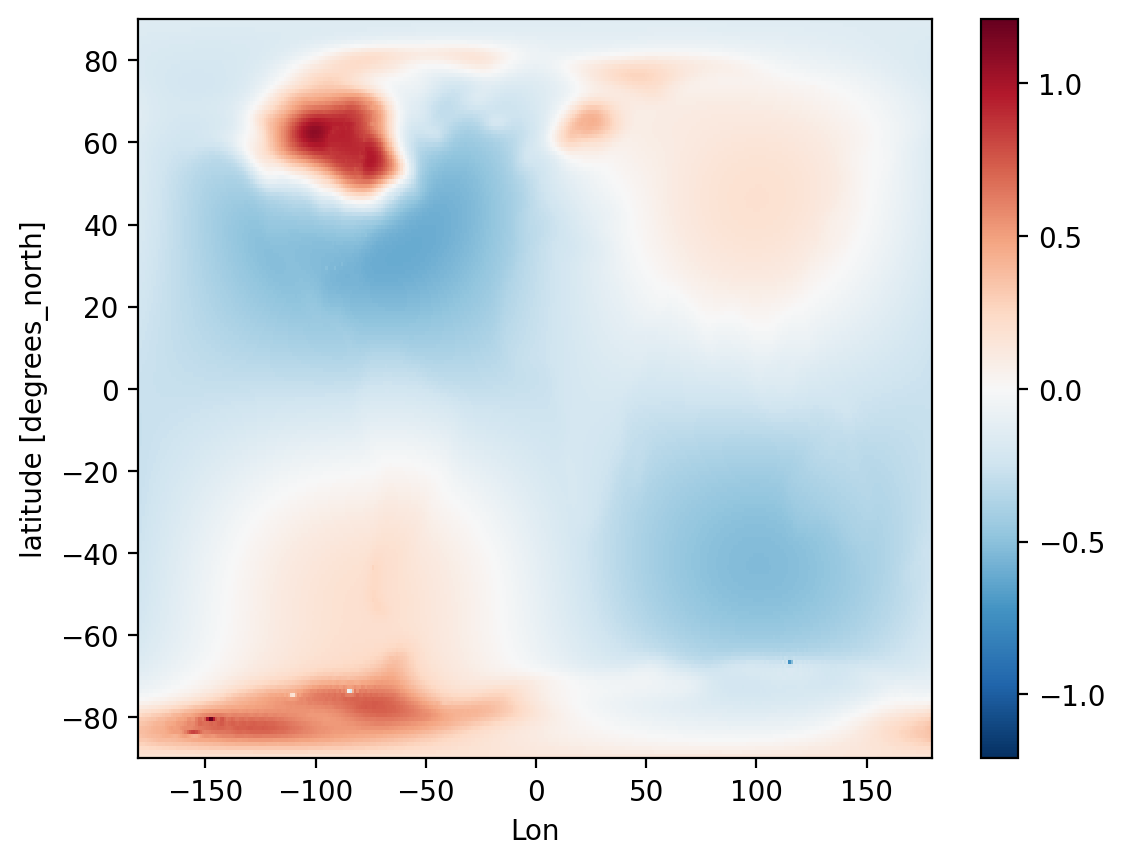

In [11]:
abs_da.plot()

In [12]:
# Use a predefined land mask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110

land_mask = land.mask_3D(abs_da.Lon, abs_da.Lat)

In [13]:
masked_abs = abs_da.where(~land_mask)

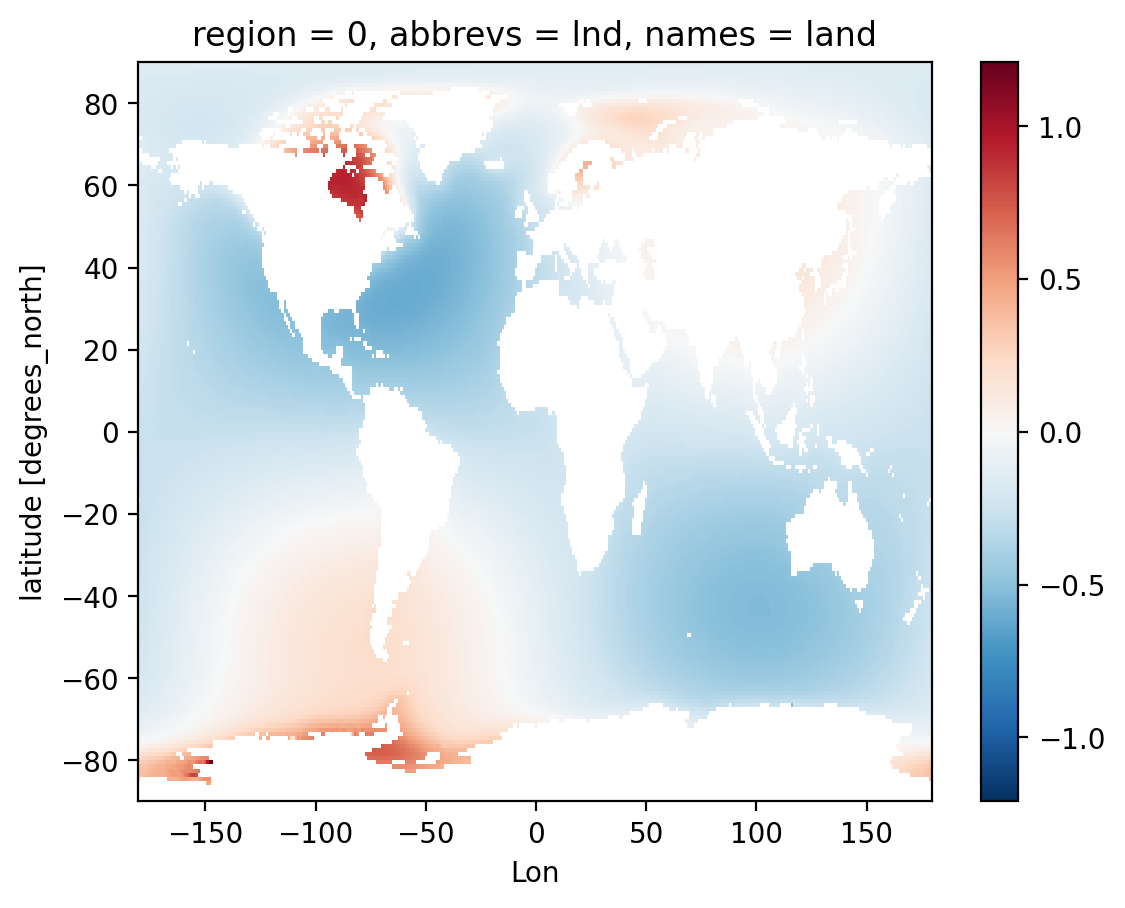

In [14]:
masked_abs.plot()

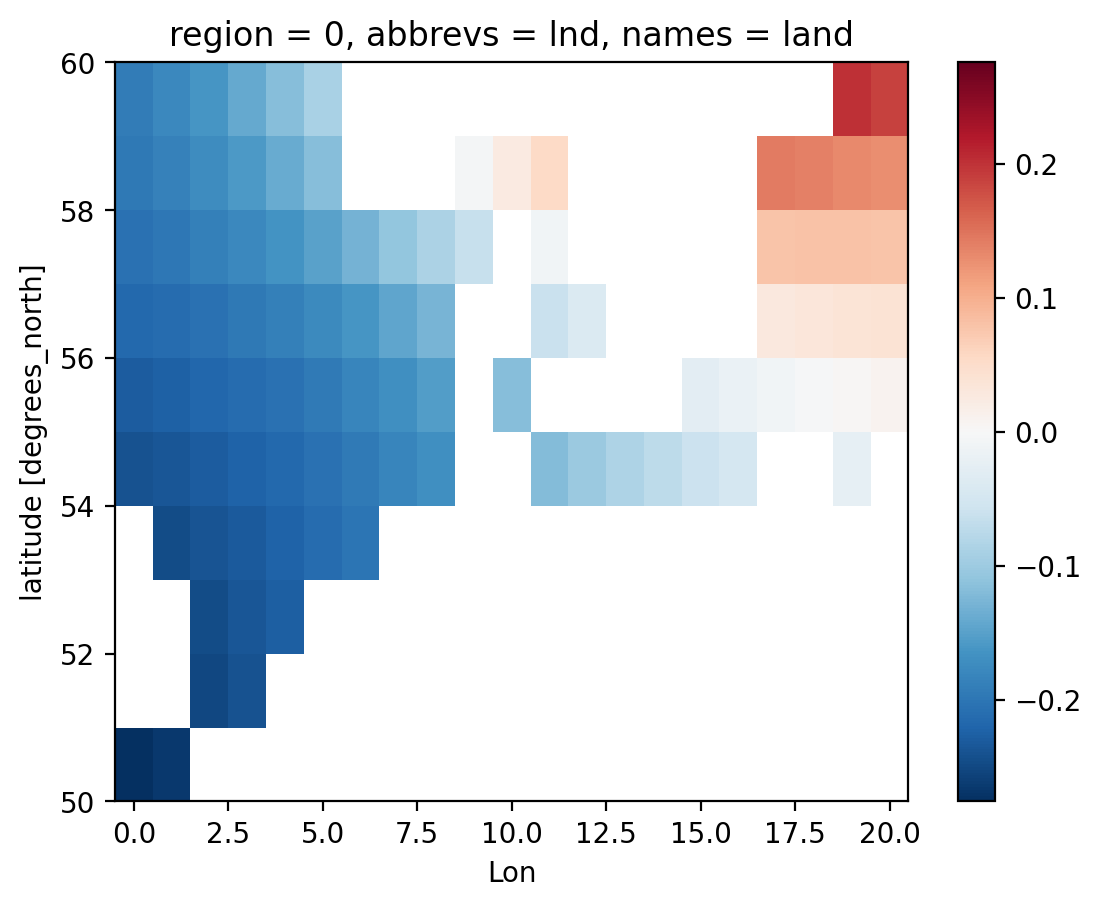

In [15]:
masked_abs.sel(Lat=slice(50,60), Lon=slice(0,20) ).plot()

Calculate the weigthed average to compare with altimetry corrections

In [16]:
weights = np.cos(np.deg2rad(masked_abs.Lat))

ocean_mean = masked_abs.weighted(weights).mean(dim=("Lat", "Lon"))

ocean_mean.data

array([-0.21664949], dtype=float32)

This is close to the -0.3 mm/yr used by AVISO to correct the altimetry signal, but not exactly...

Define the region along the North Sea used for KNMI'23

In [17]:
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

mask_NL = NLregion.mask_3D(masked_abs.Lon, masked_abs.Lat)

Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

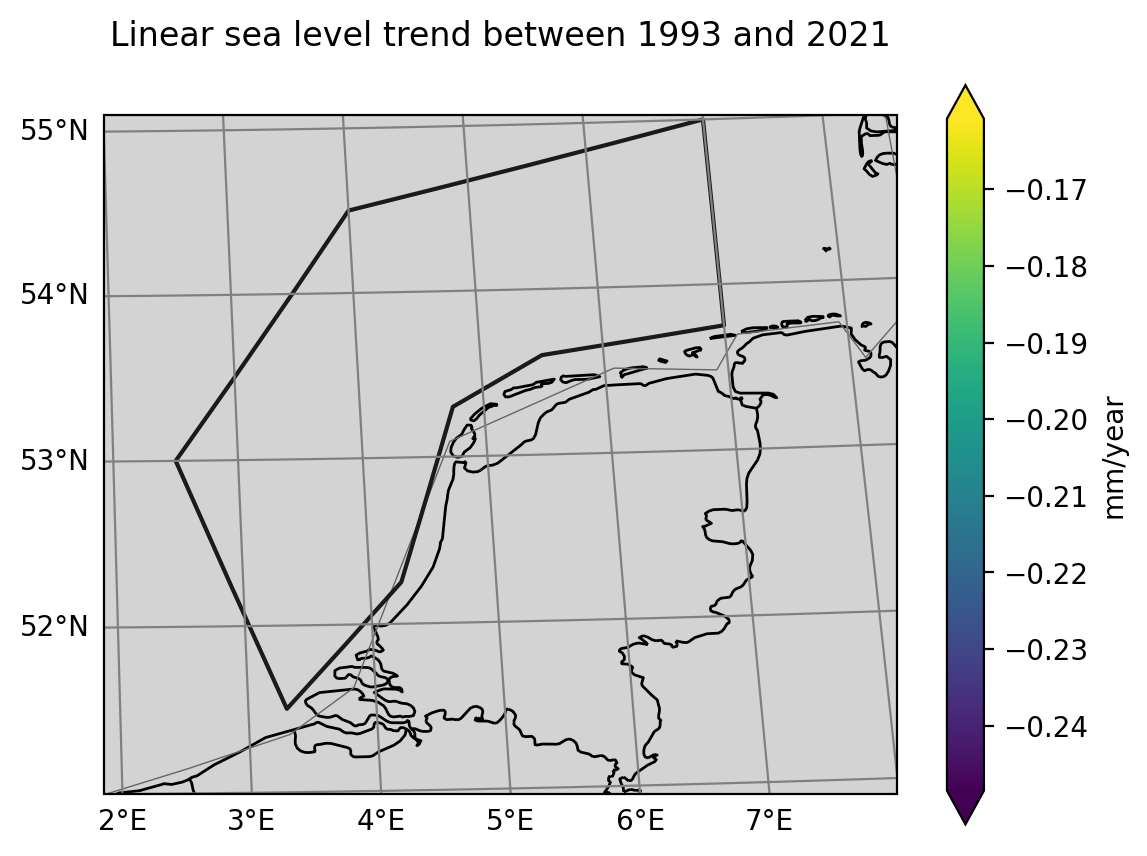

In [18]:
lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = masked_abs.sel(Lon=slice(lon_min,lon_max+1), 
                   Lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

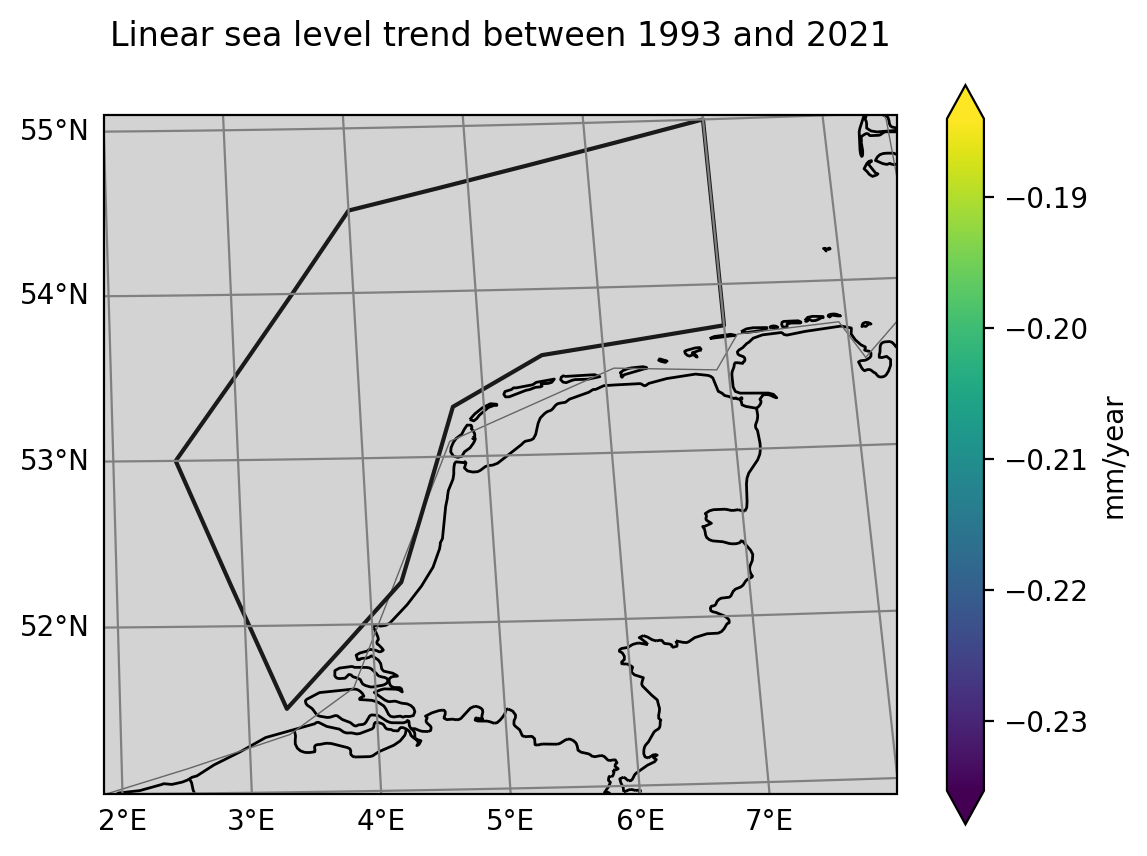

In [19]:
masked_NL_abs = masked_abs.where(mask_NL)

p = masked_NL_abs.sel(Lon=slice(lon_min-1,lon_max+1), 
                      Lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

In [22]:
region_mean = masked_NL_abs.weighted(weights).mean(dim=("Lat", "Lon"))

region_mean

<xarray.DataArray (region: 1)>
array([-0.2121041], dtype=float32)
Coordinates:
  * region   (region) int64 0

## Test function to add GIA influence on absolute sea level from altimetry

In [23]:
def speed2height_ts(variable_name, speed):
    '''Convert a speed float to a height time series dataframe'''
    
    time = np.arange(1900, 2030)
    ts = speed * (time - time[0])
    ts_list = [("time", time),(variable_name, ts)]
    ts_df = pd.DataFrame.from_dict(dict(ts_list))
    ts_df = ts_df.set_index("time")
    
    return ts_df

def GIA_ICE6G_region(location):
    '''Input region, output weigthed averaged influence of GIA on absolute sea 
    level.
    GIA has a small influence on absolute sea level. This is the sum of radial
    velocities and relative sea level which are given for ICE6G.'''
    
    dir_ICE6G = '/Users/dewilebars/Projects/SLBudget/data/GIA/ICE6G/'
    
    drad_ds = xr.open_dataset(f'{dir_ICE6G}drad.1grid_O512.nc')
    dsea_ds = xr.open_dataset(f'{dir_ICE6G}dsea.1grid_O512.nc')
    
    abs_da = dsea_ds.Dsea_250+drad_ds.Drad_250
    abs_da = abs_da.sortby(abs_da['Lat'])

    region = regionmask.Regions([location], names=['reg'], abbrevs=['reg'])
    
    mask = region.mask_3D(abs_da.Lon, abs_da.Lat)

    masked_abs_da = abs_da.where(mask)
    
    # Compute the weithed average
    weights = np.cos(np.deg2rad(masked_abs_da.Lat))
    region_mean = masked_abs_da.weighted(weights).mean(dim=("Lat", "Lon"))
    region_mean = region_mean/10 # Convert from mm/yr to cm/yr
    
    region_mean_ts_df = speed2height_ts('GIA', region_mean)
    
    return region_mean_ts_df

In [24]:
GIA_ICE6G_region(NL)

,GIA
time,
1900,-0.000000
1901,-0.021210
1902,-0.042421
1903,-0.063631
1904,-0.084842
...,...
2025,-2.651301
2026,-2.672512
2027,-2.693722


## Plot influence of GIA on relative sea level and radial displacement

In [25]:
def print_map(disp, lon_min, lon_max, lat_min, lat_max, proj, vmin, vmax):
    
    if disp == 'radial displacement':
        da = drad_ds.Drad_250
    elif disp == 'relative sea level':
        da = dsea_ds.Dsea_250
    
    p = da.sel(Lon=slice(lon_min,lon_max+1), 
                   Lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=proj, facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    vmin=vmin, vmax=vmax ,
    zorder=0)

    #p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
    p.axes.add_feature(cfeature.BORDERS)
    p.axes.coastlines()

    gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
    plt.title(f'GIA influence on {disp}', pad=25)
    
    

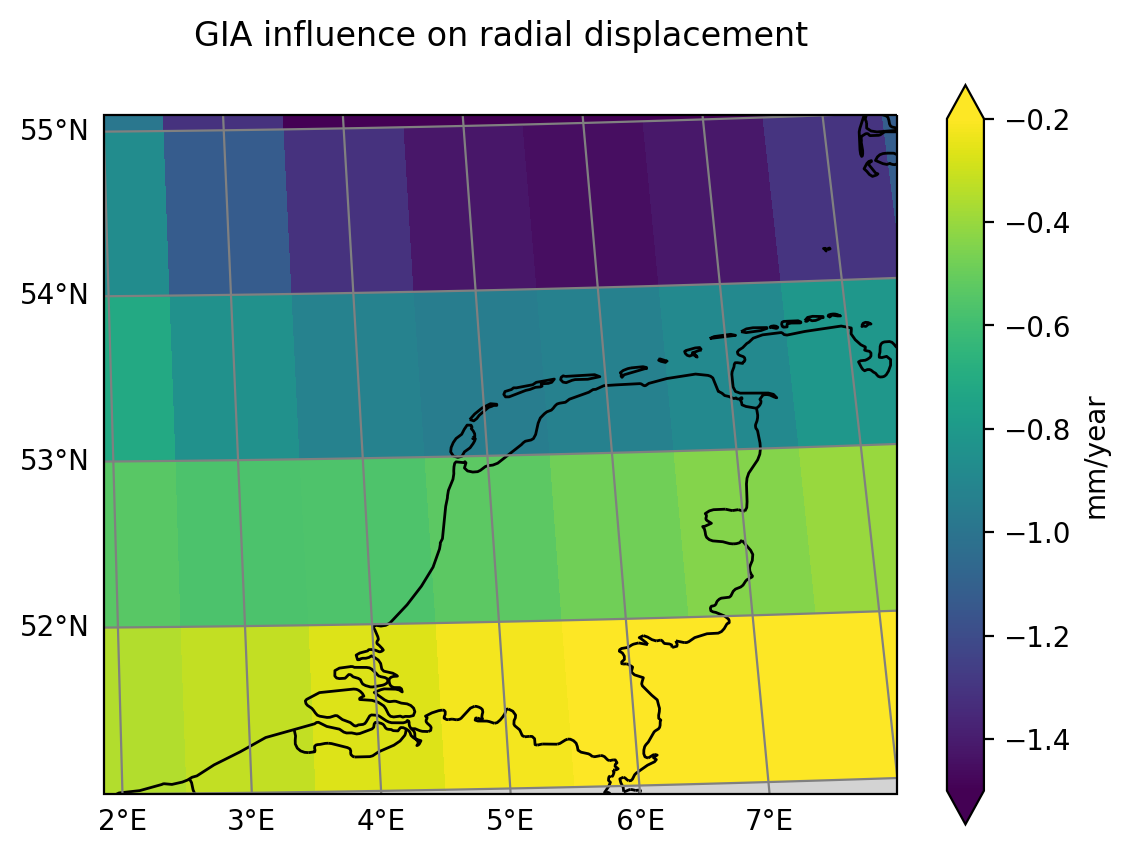

In [26]:
lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55
print_map('radial displacement',
          lon_min, lon_max, lat_min, lat_max, 
          ccrs.LambertAzimuthalEqualArea(),
          -1.5, -.2)

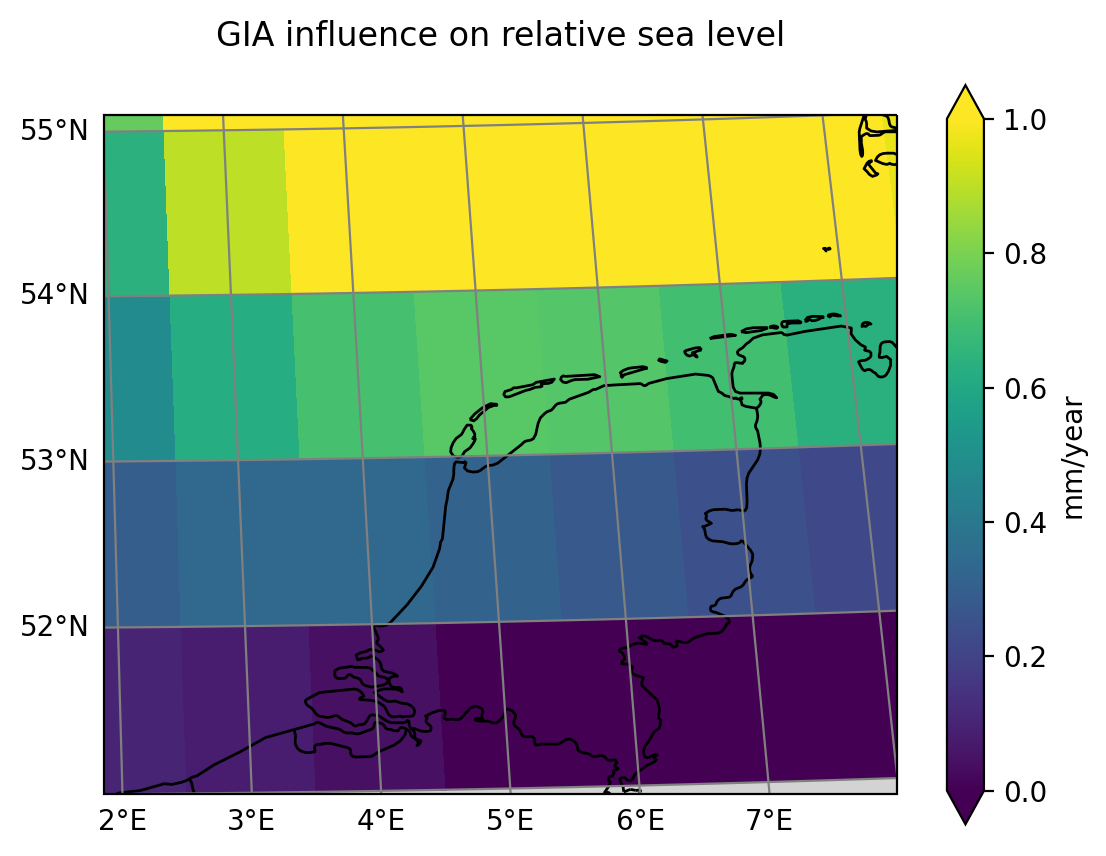

In [27]:
lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55
print_map('relative sea level',
          lon_min, lon_max, lat_min, lat_max, 
          ccrs.LambertAzimuthalEqualArea(),
          0, 1)

## Check values for Bonaire and Saba

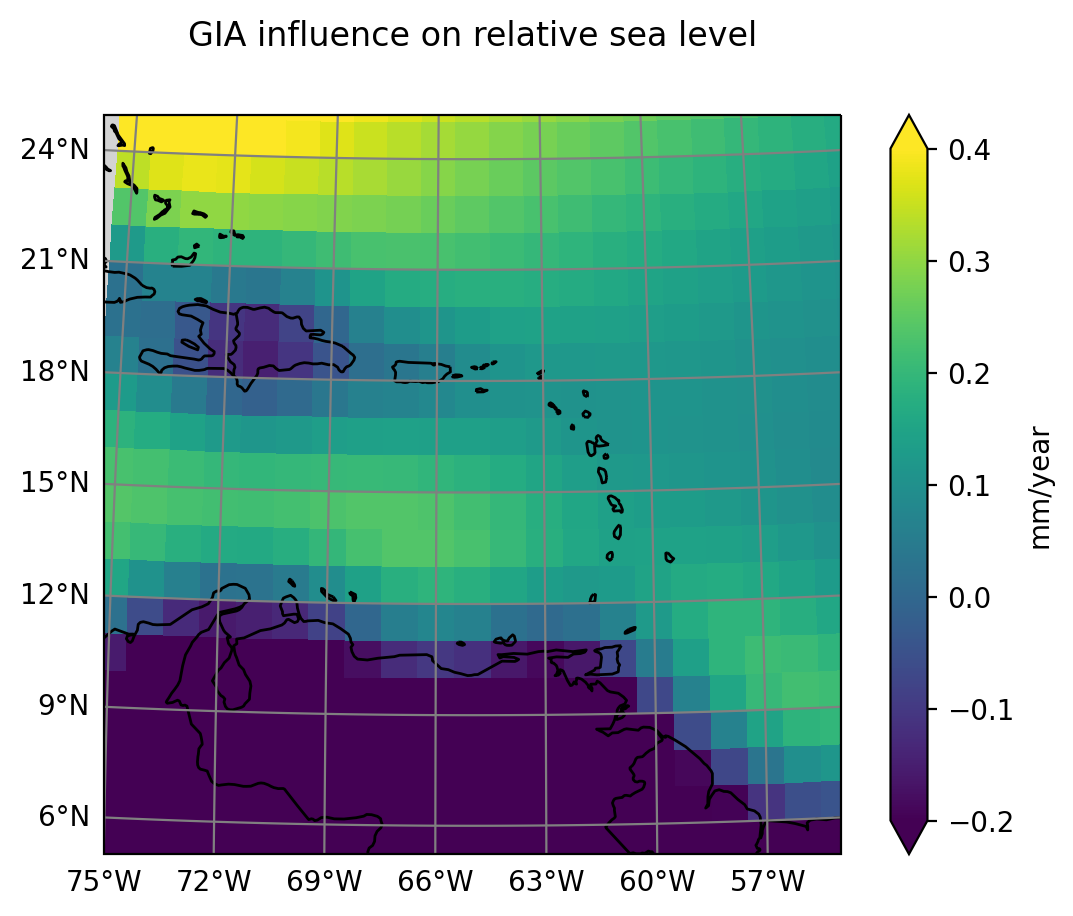

In [28]:
lon_min, lon_max, lat_min, lat_max = -75, -55, 5, 25
print_map('relative sea level', 
          lon_min, lon_max, lat_min, lat_max, 
          ccrs.Orthographic(-65, 15),
          -0.2, 0.4)

In [29]:
# Region Saba and Sint Eustatius
lat_s, lon_s = 17.6, -63.2

# Bonaire
lat_b, lon_b = 12.2, -68.3

# Curaçao
lat_cu, lon_cu = 12.2, -69.0

In [40]:
print("GIA influence on RSL in Saba:")
dsea_ds.Dsea_250.sel(Lat=lat_s, Lon=lon_s, method='nearest').values.item()

GIA influence on RSL in Saba:


0.10873715579509735

In [42]:
print("GIA influence on RSL in Bonaire:")
dsea_ds.Dsea_250.sel(Lat=lat_b, Lon=lon_b, method='nearest').values.item()

GIA influence on RSL in Bonaire:


0.14343887567520142

In [44]:
print("GIA influence on RSL in Curaçao:")
dsea_ds.Dsea_250.sel(Lat=lat_cu, Lon=lon_cu, method='nearest').values.item()

GIA influence on RSL in Curaçao:


0.09251849353313446